# Comparison with Variance-reduced Zeroth order
In this notebook, we propose some experiments in order to compare SSZD with its variance-reduced variant.

## Imports

In [1]:
import os
import numpy as np
from sszd import SSZD, SSVRZD
import matplotlib
import matplotlib.pyplot as plt
from experiments_utils.synthetic_functions import BenchmarkFunction

out_dir = "./results/variance_reduced"

os.makedirs(out_dir, exist_ok=True)

In [2]:
class SVRG_ZD:
    
    def __init__(self, f, d, l, seed = 12):
        self.d = d
        self.l = l
        self.f = f
        self.rnd_state = np.random.RandomState(seed=seed)
        
    def generate_directions(self):
        Zk = self.rnd_state.randn(self.d, self.l).astype(np.float64)
        Q_k, R_k = np.linalg.qr(Zk, mode="complete")
        diag_R_k = np.diag(R_k)
        D = (diag_R_k / np.abs(diag_R_k)) * np.eye(self.d, self.l, dtype=np.float64)        
        P_k =  np.sqrt(self.d / self.l) * Q_k.dot(D)
        return P_k
        
    def approx_gradient(self, x, z, P, h):
        grad = np.zeros(P.shape[0]) # initialize gradient as [0,...,0] \in \R^d
        fx = self.f(x, z)
        for i in range(P.shape[1]):
            grad += ((self.f(x + h * P[:, i], z) - fx)/h) * P[:, i]
        return grad
        
    def optimize(self, x, alpha, h, sample_z, cb, T = 1000, m = 100):
        for tau in range(1, T + 1): # outer loop
            h_tau = h(tau)
            P_tau = self.generate_directions()
            grad_f = self.approx_gradient(x, None, P_tau, h_tau) # \nabla f(x_\tau)
            x_k = x
            x_next = np.zeros(self.d)
            alpha_tau = alpha(tau)
            for k in range(1, m + 1):
                z_k = sample_z(self.rnd_state)
                P_k = self.generate_directions()
                grad_F = self.approx_gradient(x_k, z_k, P_tau, h_tau)
                grad_F_tau = self.approx_gradient(x, z_k, P_tau, h_tau)
                x_k = x_k - alpha(k) * (grad_F + grad_f - grad_F_tau)
            x = x_k 
            if cb is not None:
                cb(self, x)
        return x
    
    

In [3]:
class SSZD:
    
    def __init__(self, f, d, l, seed = 12):
        self.d = d
        self.l = l
        self.f = f
        self.rnd_state = np.random.RandomState(seed=seed)
        
    def generate_directions(self):
        Zk = self.rnd_state.randn(self.d, self.l).astype(np.float64)
        Q_k, R_k = np.linalg.qr(Zk, mode="complete")
        diag_R_k = np.diag(R_k)
        D = (diag_R_k / np.abs(diag_R_k)) * np.eye(self.d, self.l, dtype=np.float64)        
        P_k =  np.sqrt(self.d / self.l) * Q_k.dot(D)
        return P_k
        
    def approx_gradient(self, x, z, P, h):
        grad = np.zeros(P.shape[0]) # initialize gradient as [0,...,0] \in \R^d
        fx = self.f(x, z)
        for i in range(P.shape[1]):
            grad += ((self.f(x + h * P[:, i], z) - fx)/h) * P[:, i]
        return grad
        
    def optimize(self, x, alpha, h, sample_z, cb, T = 1000):
        for tau in range(1, T + 1): # outer loop
            h_tau = h(tau)
            P_tau = self.generate_directions()
            grad_F = self.approx_gradient(x, sample_z(self.rnd_state), P_tau, h_tau) # \nabla f(x_\tau)
            x = x - alpha(tau) * grad_F
            if cb is not None:
                cb(self, x)
        return x
    
    

In [4]:
d = 10
rnd_state = np.random.RandomState(12)

w = rnd_state.rand(d, 1)

def generate_data(n_points, w, rnd_state, sigma_noise=0.1):
    X = np.zeros((n_points, d))
    for i in range(d):
        X[:, i] = rnd_state.uniform(-1, 2, size=n_points)
    
    gauss_noise = rnd_state.normal(0, sigma_noise, size=(n_points, 1))

    y = np.dot(X, w) + gauss_noise
    
    return X, y    

n_points = 100
    
X, y = generate_data(n_points, w, rnd_state, sigma_noise=0.1)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


def mse(y, y_pred):
    return ((y - y_pred)**2).mean()

def target(w, z = None):
    w = w.reshape(-1, 1)
    if z is None:
        X, y = X_train, y_train
    else:
        X, y = z
    y_pred = X.dot(w)
    return mse(y, y_pred)

In [6]:
def sample_z(rnd_state):
    idx = rnd_state.randint(low=0, high=X_train.shape[0])
    return (X_train[idx, :], y_train[idx, :])

l = d

In [33]:
zd = SSZD(target, d, l, seed = 12)
sszd = SSZD(target, d, l, seed = 12)
svrg_zd = SVRG_ZD(target, d, l, seed = 12)
w = np.zeros(d) + 200
alpha = lambda k : 0.01 * 1/np.sqrt(k)
h = lambda k : 1/k

#    def optimize(self, x, alpha, h, sample_z, cb, T = 1000, m = 100):


results_zd = [target(w)]
results_sszd = [target(w)]
results_vr = [target(w)]
results_rv = [target(w)]

def cb_sszd(opt, x):
    results_sszd.append(target(x))

def cb_vr(opt, x):
    results_vr.append(target(x))

def cb_rv(opt, x):
    results_rv.append(target(x))

def cb_zd(opt, x):
    results_zd.append(target(x))

T_vr = 100
m = 100

T_sz = T_vr * (m + X_train.shape[0])

rs_sszd = []
rs_vr = [] 
for _ in range(10):   
    w_sszd = sszd.optimize(w, alpha, h, sample_z, cb_sszd, T = T_sz)
    w_vr = svrg_zd.optimize(w, alpha, h, sample_z, cb_vr, T = T_vr, m = m)
    rs_sszd.append(results_sszd)
    rs_vr.append(results_vr)
    w = np.zeros(d) + 200
    results_sszd, results_vr = [target(w)], [target(w)]
    



In [36]:
len(rs_sszd[0])

17001

In [41]:
results_sszd, std_sszd = np.mean(np.asarray(rs_sszd).reshape(10, -1), axis=0), np.std(np.asarray(rs_sszd).reshape(10, -1), axis=0)
results_vr, std_vr = np.mean(np.asarray(rs_vr).reshape(10, -1), axis=0), np.std(np.asarray(rs_vr).reshape(10, -1), axis=0)

results_vr_repl = np.asarray([results_vr[0]] + [v for v in results_vr[1:] for i in range(m + X_train.shape[0])])
std_vr = np.asarray([std_vr[0]] + [v for v in std_vr[1:] for i in range(m + X_train.shape[0])])

len(results_vr_repl)


17001

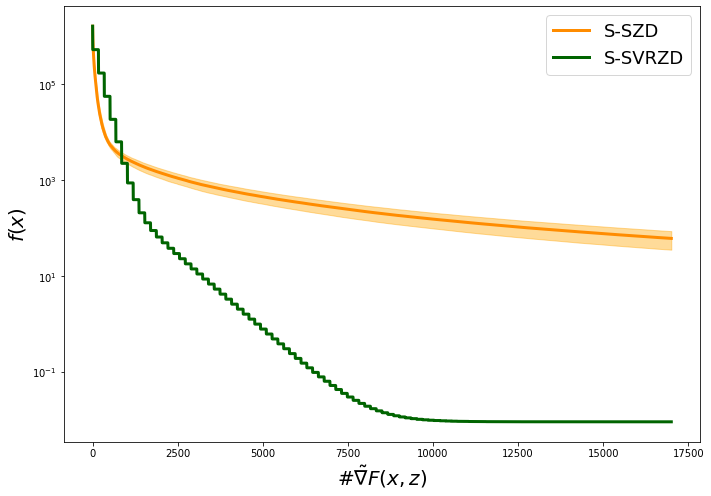

In [60]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(range(len(results_sszd)), results_sszd, '-', color='darkorange', lw=3, label='S-SZD')
ax.fill_between(range(len(results_sszd)), results_sszd + std_sszd, results_sszd - std_sszd,  color='orange', alpha=0.4)
ax.plot(range(len(results_sszd)), results_vr_repl, '-', color='darkgreen', lw=3, label='S-SVRZD')
ax.fill_between(range(len(results_sszd)), results_vr_repl + std_vr, results_vr_repl - std_vr,  color='green', alpha=0.4)
ax.set_yscale("log")
ax.set_xlabel("$\# \\tilde{\\nabla} F(x, z)$", fontsize=20)
ax.set_ylabel("$f(x)$", fontsize=20)
ax.legend(fontsize=18)
fig.tight_layout()
plt.savefig("./results/variance_reduced/linear_reg.pdf", bbox_inches='tight')